## ResNet Constructor.
Данный ноутбук содержит контруктор ResNet подобных сетей и пайплайн для работы с ним.
- accuracy на тестовой части датасета Imagenette составляет 0.92
- в pipeline'e реализовано сохранения метрик и модели 

### Oсновые блоки
[Загрузка датасета](#Загрузка-датасета) <br>
[Гиперпараметры обучения](#Гиперпараметры-обучения) <br>
[Просмотр датасета](#Просмотр-датасета) <br>
[Конструктор ResNet-like моделей](#Конструктор-ResNet-подобных-сетей) <br>
[Инициализация модели](#Инициализация-модели) <br>
[Тренировочный цикл](#Тренировочный-цикл) <br>
[Проверка модели](#Проверка-модели) <br>
[Критика](#Критика)

In [1]:
import time
import warnings

import numpy as np
import pandas as pd
import torch
from torch import nn
from torchvision import transforms, datasets, utils

from modules import datasets_loader, CNN_blocks, get_optimizer, get_sheduler, train_step, metrics_calc

warnings.filterwarnings('ignore')

### Загрузка датасета

In [2]:
# dataset_path = datasets_loader.imagenette_loader(path='../imagenette/', need_install=False)
# dataset_path

- need_install: используйте True, если нужно установить fastai

### Гиперпараметры обучения

In [3]:
batch_size = 32
num_epoch = 200
learning_rate = 0.001
optimizer_type = 'Adam'
save_best_model = True

# resnet architecture
resnet_layers = [2,2,2,2]
bottleneck = False
num_classes = 10

# learning_rate_decay
sheduler_type = 'cos'
sheduler_cycle = 1

dataset_path = '../imagenette/imagenette2-320/'
save_model_dir = './models/'
metrics_dir = './metrics/'

- batch_size: кол-во изображений в одном батче. Предел зависит от кол-ва памяти на видеокарте
- num_epoch: кол-во эпох обучения.
- learning_rate: скорость обучения.
- optimizer_type: тип оптимизатора, использующегося для обновления весов сети. Может быть 'SGD' или 'Adam'

<b>Архитектура сети:
 - layers - список с количеством стандартных блоков по слоям
 - num_classes - количество классов
 - bottleneck - определяет использование стандартных блоков или 'bottleneck' блоков <br>

(!) Конструктор ожидает на вход изображение с разрешением 224х224х3

Примеры стандартных сетей:<br>
<b>ResNet-18: </b> <br> 
model = ResNet_like(layers=[2,2,2,2], bottleneck=False, num_classes=10)

<b>ResNet-34: </b> <br> 
model = ResNet_like(resnet_layers=[3,4,6,3], bottleneck=False, num_classes=10)

<b>ResNet-50: </b> <br> 
model = ResNet_like(resnet_layers=[3,4,6,3], bottleneck=True, num_classes=10)

<b>ResNet-101: </b> <br> 
model = ResNet_like(resnet_layers=[3,4,23,3], bottleneck=True, num_classes=10)

<b>ResNet-152: </b> <br> 
model = ResNet_like(resnet_layers=[3,8,36,3], bottleneck=True, num_classes=10)
    
<b>Настройка изменения learning rate в течении обучения. </b><br> 
Реализовано две стратегии 'cos' - согласно функции косинуса и 'step' - ступенчатое уменьшение в 10 раз через равные промежутки.
- sheduler_type: задает стратегию изменения скорости обучения в течении обучения. может быть 'cos' или 'step'
- sheduler_cycle: задает кол-во циклов изменения learning rate. Должно быть меньше или равно num_epoch<br> 
Для 'cos' интерпритируется как кол-во циклов убывания learning rate с возвратом к стартовому learning rate в начале нового цикла<br>
Для 'step' интерпритируется как кол-во уменьшений learning rate

Прочее
- dataset_path: путь к папке с датасетом

Задаем название модели, которое будет фигурировать в названии сохраненных файлов метрики и модели<br>
Название модели является производным от гиперпараметров

In [4]:
m = 3 if bottleneck else 2
model_name = f'ResNet{sum(resnet_layers)*m+2}_{optimizer_type}_lr{learning_rate}_b{batch_size}_{sheduler_type}_sc{num_epoch//sheduler_cycle}'
model_name

'ResNet18_Adam_lr0.001_b32_cos_sc200'

### Просмотр датасета

Посмотрим csv, приложенный к датасету

In [5]:
labels_df = pd.read_csv('../imagenette/imagenette2-320/noisy_imagenette.csv')
labels_df.head()

,path,noisy_labels_0,noisy_labels_1,noisy_labels_5,noisy_labels_25,noisy_labels_50,is_valid
0,train/n02979186/n02979186_9036.JPEG,n02979186,n02979186,n02979186,n02979186,n02979186,False
1,train/n02979186/n02979186_11957.JPEG,n02979186,n02979186,n02979186,n02979186,n03000684,False
2,train/n02979186/n02979186_9715.JPEG,n02979186,n02979186,n02979186,n03417042,n03000684,False
3,train/n02979186/n02979186_21736.JPEG,n02979186,n02979186,n02979186,n02979186,n03417042,False
4,train/n02979186/ILSVRC2012_val_00046953.JPEG,n02979186,n02979186,n02979186,n02979186,n03394916,False


In [6]:
for cols in labels_df.columns:
    print(cols, ' have ', len(labels_df[cols].unique()), 'labels')

path  have  13394 labels
noisy_labels_0  have  10 labels
noisy_labels_1  have  10 labels
noisy_labels_5  have  10 labels
noisy_labels_25  have  10 labels
noisy_labels_50  have  10 labels
is_valid  have  2 labels


Кол-во картинок в тренировочном датасете

In [7]:
train_img_qty = len(labels_df[labels_df['is_valid'] == False].index)
train_img_qty

9469

Кол-во картинок в тестовом датасете

In [8]:
test_img_qty = len(labels_df[labels_df['is_valid'] == True].index)
test_img_qty

3925

### Создаем DataLoader попутно предобрабатывая данные

В качетсве аугментаций ипользуется:
- уменьшение картинки до разрешения 260*260
- вырезка случайного квадрата размером 224*224 (сеть ожидает именно эту размерность)
- переворот изображения по горизонтальной оси
- нормализация

In [9]:
train_transform = transforms.Compose([
        transforms.Resize((260,260)),
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
test_transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

trainset = datasets.ImageFolder(root=dataset_path + '/train/', transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)
testset = datasets.ImageFolder(root=dataset_path + '/val/', transform=test_transform)
testloader = torch.utils.data.DataLoader(testset,
                                         shuffle=False)

Давайте глянем на примеры картинок в тренировочном датасете после применения аугментаций

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


cassette player


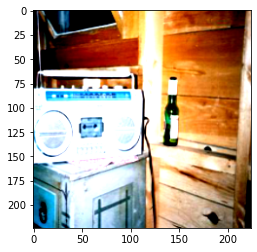

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


parachute


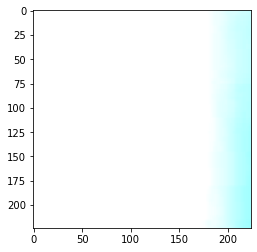

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


gas pump


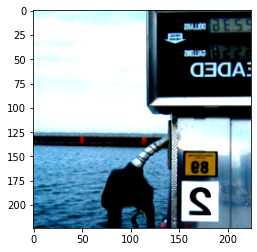

French horn


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


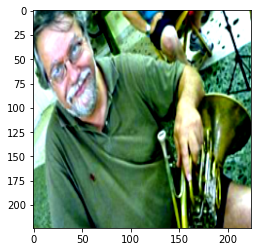

In [10]:
show_subset = torch.utils.data.Subset(trainset, np.random.randint(0,high=len(trainset), size=4))
show_subset_loader = torch.utils.data.DataLoader(show_subset, shuffle=False)
for images, labels in show_subset_loader:
    print(datasets_loader.label_func(int(labels)))
    datasets_loader.visual_tensor(utils.make_grid(images))

## Конструктор ResNet подобных сетей

(!) Конструктор ожидает на вход изображение с разрешением 224х224х3<br>

Данный класс собирает готовую модель из ResNet-блоков <br>
Блоки ожидают параметры:
 - num_layer - порядковый номер слоя, в котором будет использоваться данных блок. В стандартной ResNet архитектуре ResNet блоки используются со второго слоя.
 - downsample - определяет тип downsampling'а.
     - 0 - downsampling не используется
     - 1 - downsampling используется в блоке, где уменьшается разрешение и увеличивается кол-во каналов
     - -1 - downsampling используется в блоке, где разрешение не уменьшается, но увеличивается кол-во каналов (обычно последний слой)

In [11]:
class ResNet_like(nn.Module):

    def __init__(self, 
                 layers, 
                 num_classes,
                 bottleneck,
                 ):
        
        super(ResNet_like, self).__init__()
        self.first = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        
        self.body = nn.Sequential()
        if bottleneck:
            for num, layer in enumerate(layers):
                for block in range(layer):
                    if block == 0  and num < len(layers) - 1:
                        downsample = 1
                    elif block == 0 and num == len(layers) - 1:
                        downsample = -1
                    elif block != 0:  
                        downsample = 0
                    self.body.add_module(name='block_%d_%d'%(num+2,block+1), module=CNN_blocks.ResNet_Bottleneck_Block(num+2, downsample))
        elif not bottleneck:
            for num, layer in enumerate(layers):
                for block in range(layer):
                    if block == 0  and num < len(layers) - 1:
                        downsample = 1
                    elif block == 0 and num == len(layers) - 1:
                        downsample = -1
                    elif block != 0:  
                        downsample = 0
                    self.body.add_module(name='block_%d_%d'%(num+2,block+1), module=CNN_blocks.ResNet_Normal_Block(num+2, downsample))
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        m = 4 if bottleneck else 1
        self.linear_input = 32*(2**(len(layers))) * m
        self.linear = nn.Linear(self.linear_input, num_classes)
        
    def forward(self, x):

        x = self.first(x)
        x = self.body(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
       
        return x

## Инициализация модели

Задаем оптимизаторы и создаем планировщик убывания скорости обучения

In [12]:
model = ResNet_like(layers=resnet_layers, bottleneck=bottleneck, num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = get_optimizer.get(model, optimizer_type, learning_rate)
scheduler = get_sheduler.get(optimizer, sheduler_type, cycles=num_epoch//sheduler_cycle)

Загружаем модель на видеокарту.

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


ResNet_like(
  (first): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (body): Sequential(
    (block_2_1): ResNet_Normal_Block(
      (downsample): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (block_2_2): ResNet_Normal_Block(
      (conv1): Conv2d(64, 64, kernel_size=(3

Создадим папки для сохранения моделей и метрик

In [14]:
datasets_loader.create_dir(save_model_dir)
datasets_loader.create_dir(metrics_dir)

already created
already created


Создаем датафрейм для записи метрик обучения. <br>
Датафрейм сохраняется в папку './metrics'

In [15]:
cols_name = ['epoch', 'time', 'current_lr', 'loss', 'accuracy_train', 'accuracy_val']
metrics_frame = pd.DataFrame(columns=cols_name)
metrics_frame_file = (metrics_dir + model_name + '.csv')
metrics_frame_file

'./metrics/ResNet18_Adam_lr0.001_b32_cos_sc200.csv'

## Тренировочный цикл

    - Основная метрика accuracy (топ1).
    - Метрика сохраняется в словарь и из словаря сохраняется в датасет и выводится на экран.
    - Лучшая мадель согласно валидации сохраняется на диск.

In [ ]:
for epoch in range(num_epoch):  # loop over the dataset multiple times

    model.train()
    start_time = time.time()
    for _, data in enumerate(trainloader, 0):
        loss, outputs = train_step.make_step(data, optimizer, model, criterion, device)
    scheduler.step()
    
    #Accuracy train and val
    model.eval()
    accuracy_train = metrics_calc.approx_accuracy(trainset, model, device, reduce=16)
    accuracy_val = metrics_calc.approx_accuracy(testset, model, device, reduce=4)
    
    if accuracy_val >= .88 and accuracy_val >= metrics_frame['accuracy_val'].max():
        accuracy_val = metrics_calc.true_accuracy(testloader, model, device)

    end_time = time.time()
    metrics = {'epoch': epoch+1,
               'time': end_time - start_time,
               'current_lr': [group['lr'] for group in optimizer.param_groups][0],
               'loss': float(loss),
               'accuracy_train': accuracy_train,
               'accuracy_val': accuracy_val,
               }

    print("Epoch {}/{}, Time: {:.2f} sec, current_lr: {:.2e}, Loss: {:.3f}, Accuracy_train: {:.3f}, Accuracy_val: {:.3f}".
          format(metrics['epoch'], num_epoch, metrics['time'], metrics['current_lr'], metrics['loss'], metrics['accuracy_train'], metrics['accuracy_val']))
    
    metrics_frame = metrics_frame.append(pd.DataFrame.from_dict(metrics,orient='index').T)
    metrics_frame.to_csv(metrics_frame_file,index=False)
    
    if save_best_model:
        if metrics['accuracy_val'] == metrics_frame['accuracy_val'].max():
            torch.save(model, save_model_dir + model_name + '.pt')
if not save_best_model:
    torch.save(model, save_model_dir + model_name + '.pt')

Epoch 1/200, Time: 59.00 sec, current_lr: 1.00e-03, Loss: 2.012, Accuracy_train: 0.370, Accuracy_val: 0.378
Epoch 2/200, Time: 58.82 sec, current_lr: 1.00e-03, Loss: 2.288, Accuracy_train: 0.465, Accuracy_val: 0.468


### Проверка модели

Посмотрим сохраненные в процессе обучения метрики

In [25]:
metrics_frame.tail()

,epoch,time,current_lr,loss,accuracy_train,accuracy_val
0,196.0,59.793560,9.866358e-07,0.926303,0.967905,0.880734
0,197.0,86.296144,5.550625e-07,0.385872,0.957770,0.894268
0,198.0,60.713772,2.467198e-07,0.011071,0.945946,0.879715
0,199.0,88.772812,6.168376e-08,0.043817,0.972973,0.896051
0,200.0,60.800678,1.000000e-03,0.035993,0.966216,0.879715


Посмотрим лучший результат на валидации

In [26]:
metrics_frame[metrics_frame['accuracy_val'] == metrics_frame['accuracy_val'].max()]

,epoch,time,current_lr,loss,accuracy_train,accuracy_val
0,165.0,85.036059,0.000074,0.53303,0.945946,0.899873


Проверяем сохраненную модель на соответствие метрикам в процессе обучения.

In [27]:
model = torch.load(save_model_dir + model_name + '.pt')
model.eval()

ResNet_like(
  (first): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (body): Sequential(
    (block_2_1): ResNet_Normal_Block(
      (downsample): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (block_2_2): ResNet_Normal_Block(
      (conv1): Conv2d(64, 64, kernel_size=(3

In [ ]:
accuracy_check = metrics_calc.true_accuracy(testloader, model, device)

print(f'Accuracy saved model on the validation dataset is: {accuracy_check:.3f}')

### Критика

Известные проблемы:
- результат очень сильно зависит от стартового learning_rate. learning_rate для используемых оптимизаторов нужно выбирать в разном диапазоне (0,01-0,1 для SGD и 0,0005-0,03 для Adam), что приводит к некоторой путанице
- результат ниже baseline от fastai на 3 пункта
- датасет imagenette недостаточно большой, чтобы раскрыть возможности контруктора. Лучший результат получается с помощью ResNet-18 и ResNet-34
- данный ноутбук может приводить к большой нагрузку на CPU, хотя обучение модели происходит на GPU